### base64
https://stackoverflow.com/questions/22351254/python-script-to-convert-image-into-byte-array/22351973

In [4]:
import base64
import os

from PIL import Image
from netCDF4 import Dataset
import numpy as np

In [5]:
import base64
import os
import numpy as np
from PIL import Image
from netCDF4 import Dataset
from scipy.ndimage.filters import uniform_filter

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

os.chdir('/home/dhkim/projects/gk2aICT/')
from src.config import (
    GK2A_DATA_PATH,
)
from src.variables import (
    VAR2DSKEY,
    FD_VAR2FILE,
)
from src.tools.clip import (
    GK2AFDProcessor,
)


In [6]:
base_path = GK2A_DATA_PATH # set your data location
obs_datetime = '202111190300' # set your interesting datetime

In [8]:
var = 'swrad'
file_name = FD_VAR2FILE[var].format(target_datetime=obs_datetime)
ds = Dataset(os.path.join(base_path, file_name))
arr = np.array(ds[VAR2DSKEY[var][0]][:])

In [9]:
# gk2a_proc = GK2AProcessor(resolution=1.00)
gk2a_proc = GK2AFDProcessor(gk2a_filename=file_name)

In [10]:
midpoint = [int(i/2) for i in arr.shape]
print(midpoint)

[2750, 2750]


In [11]:
latlon_from_rowcol = gk2a_proc.latlon_from_rowcol(*[int(i/2) for i in arr.shape])
print(latlon_from_rowcol)

(0.009061819885547611, 128.19099884330967)


In [12]:
gk2a_proc.rowcol_from_latlon(*latlon_from_rowcol)

(2750.0000000028676, 2750.000000002963)

In [13]:
gk2a_proc.rowcol_from_latlon(*(43.07, 124.0))

(696.8101588351028, 2587.7965600118164)

In [48]:
ko_range = {
    'ullatitude': 43.0,
    'ullongitude': 124.0,
    'lrlatitude': 33.0,
    'lrlongitude': 132.0,
}
ea_range = {
    'ullatitude': 53,
    'ullongitude': 77,
    'lrlatitude': 11,
    'lrlongitude': 150,
}
etc_range = {
    'ullatitude': 39.0,
    'ullongitude': 126.0,
    'lrlatitude': 36.0,
    'lrlongitude': 128.0,
}

In [49]:
arr_ea = gk2a_proc.cut_with_latlon(arr, **ea_range)
arr_ko = gk2a_proc.cut_with_latlon(arr, **ko_range)
arr_etc = gk2a_proc.cut_with_latlon(arr, **etc_range)

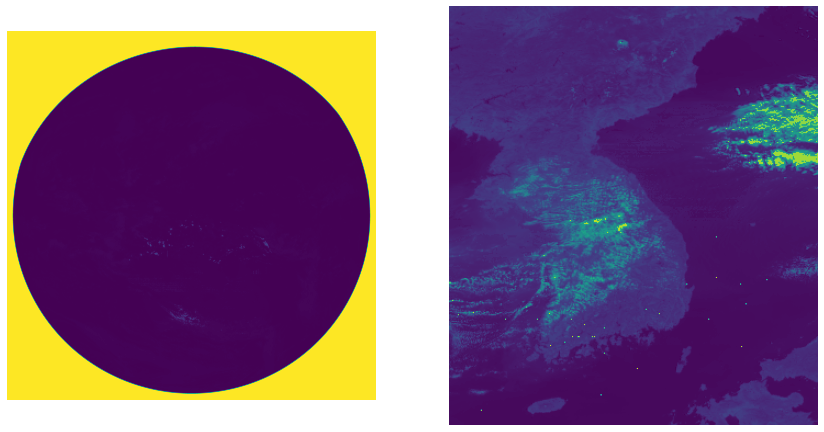

In [16]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr)
ax[0].axis('off')
ax[1].imshow(arr_ko)
ax[1].axis('off')
fig.subplots_adjust(right=2, top=2)

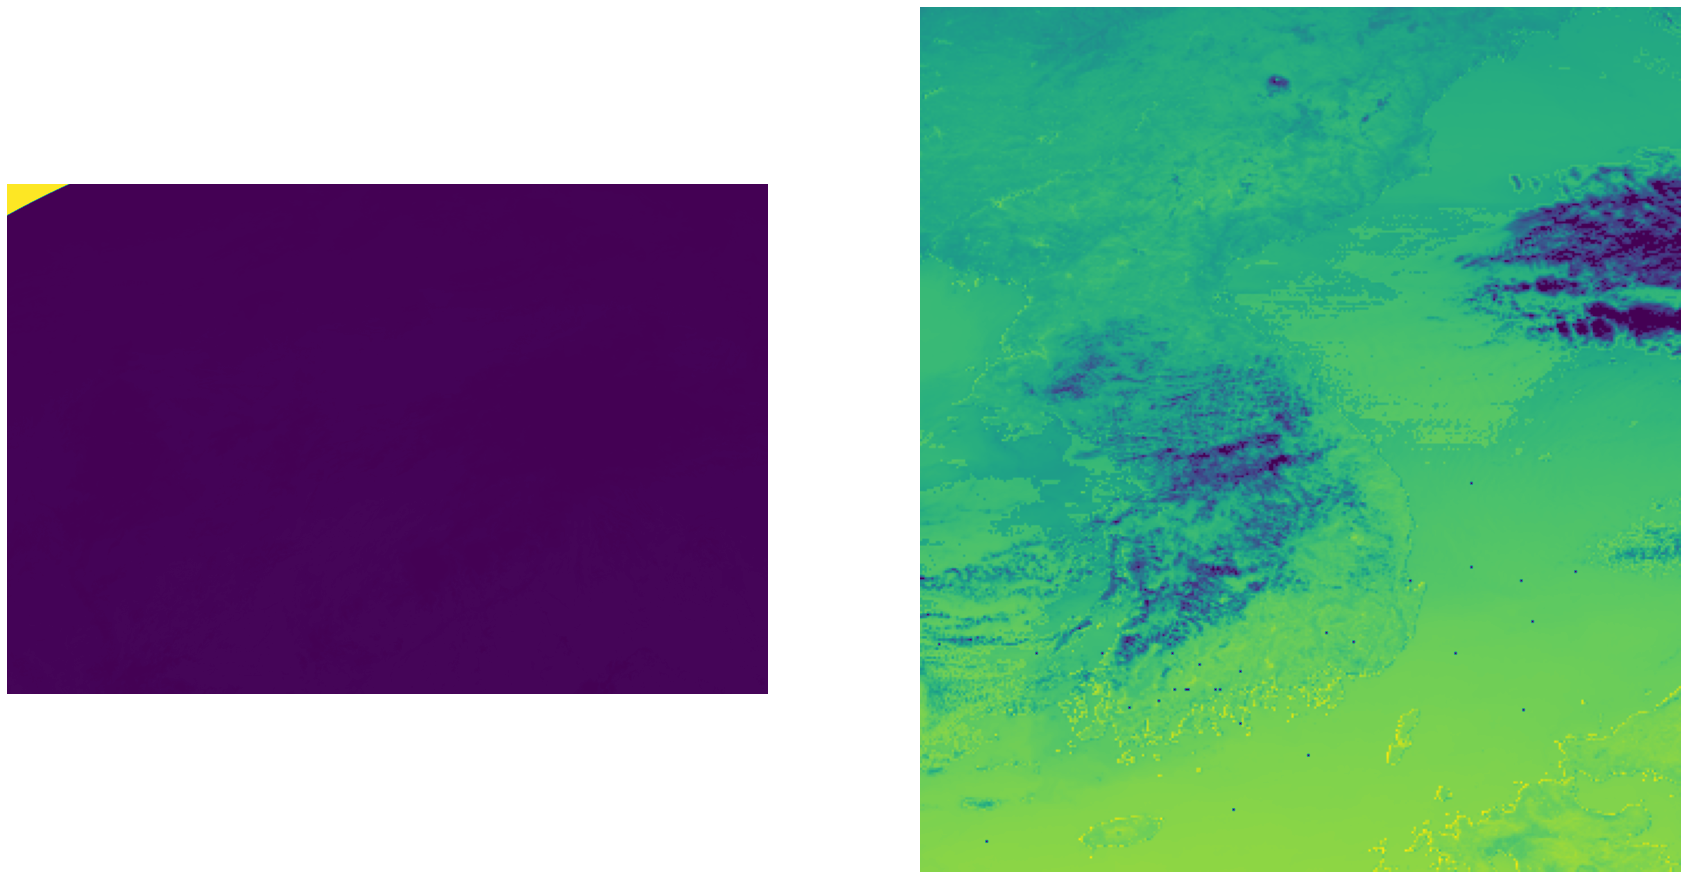

In [13]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr_ea)
ax[0].axis('off')
ax[1].imshow(arr_ko)
ax[1].axis('off')
fig.subplots_adjust(right=4, top=4)

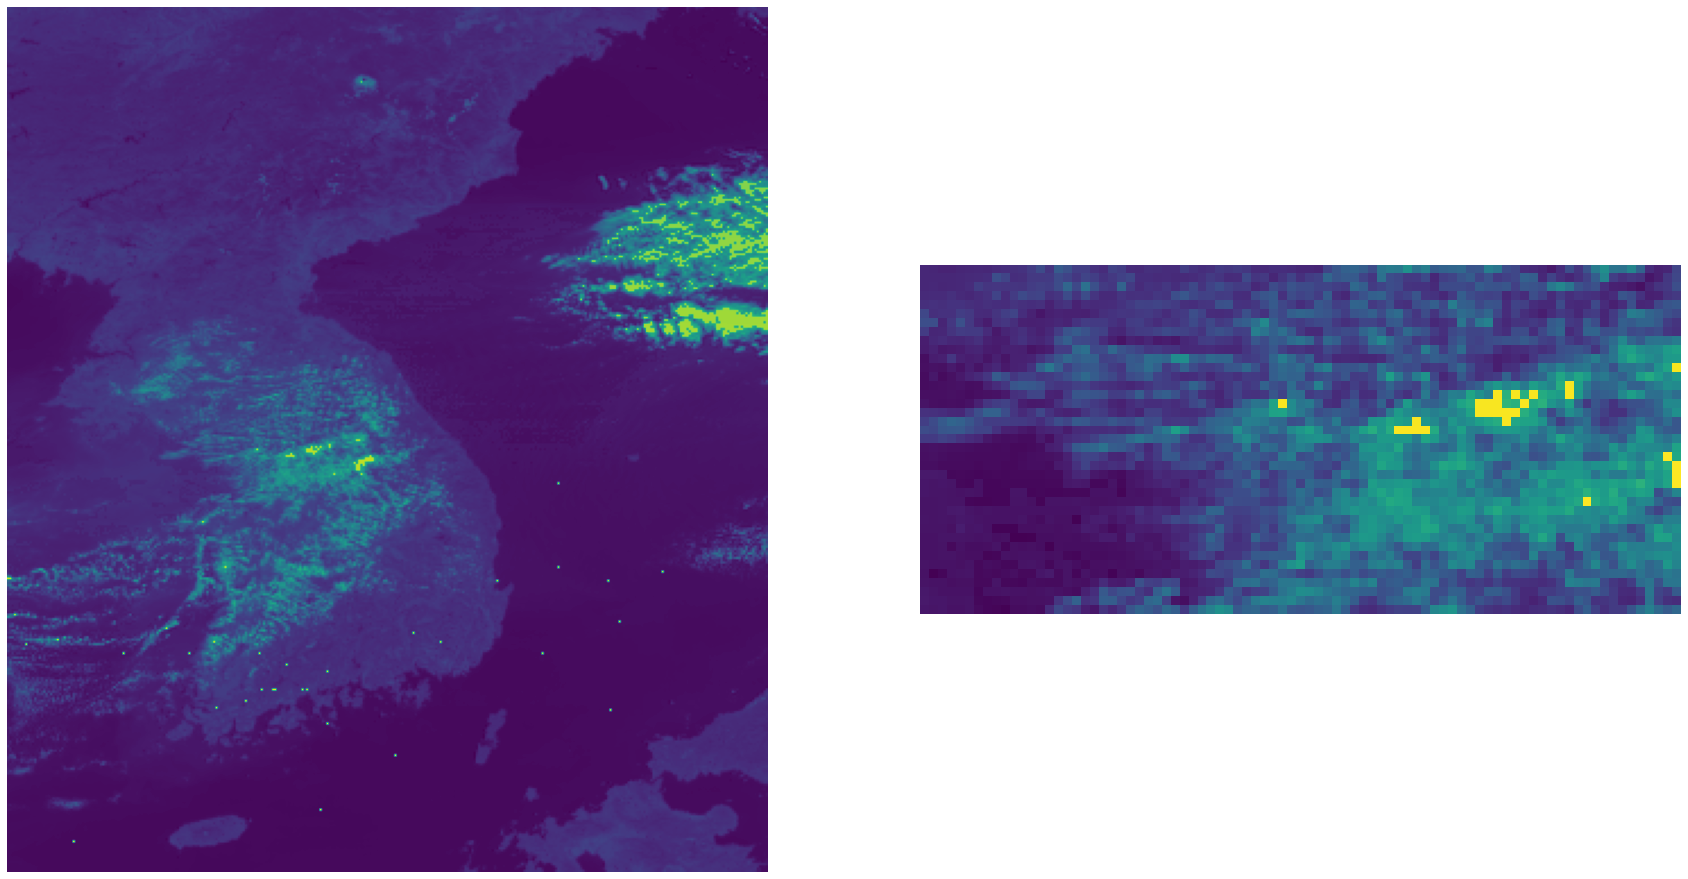

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr_ko)
ax[0].axis('off')
ax[1].imshow(arr_etc)
ax[1].axis('off')
fig.subplots_adjust(right=4, top=4)

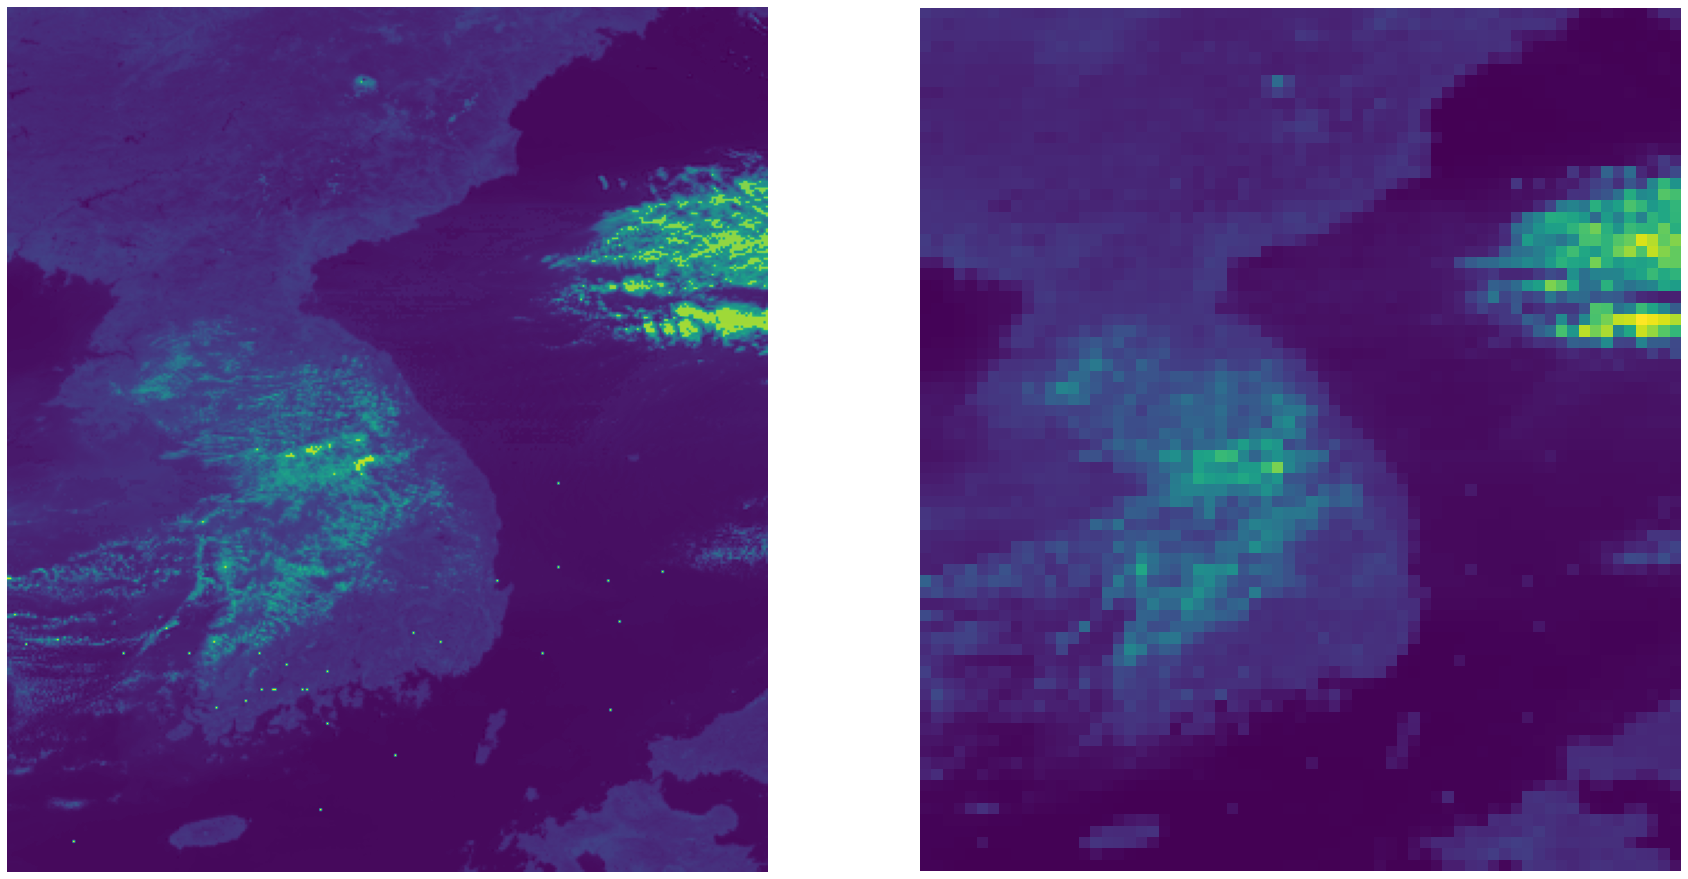

In [52]:
res_magnify_ratio = 0.2
arr_clip_res_down = cv2.resize(
    arr_ko,
    dsize=None,
    fx=res_magnify_ratio,
    fy=res_magnify_ratio,
    interpolation=cv2.INTER_AREA
)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr_ko)
ax[0].axis('off')
ax[1].imshow(arr_clip_res_down)
ax[1].axis('off')
fig.subplots_adjust(right=4, top=4)

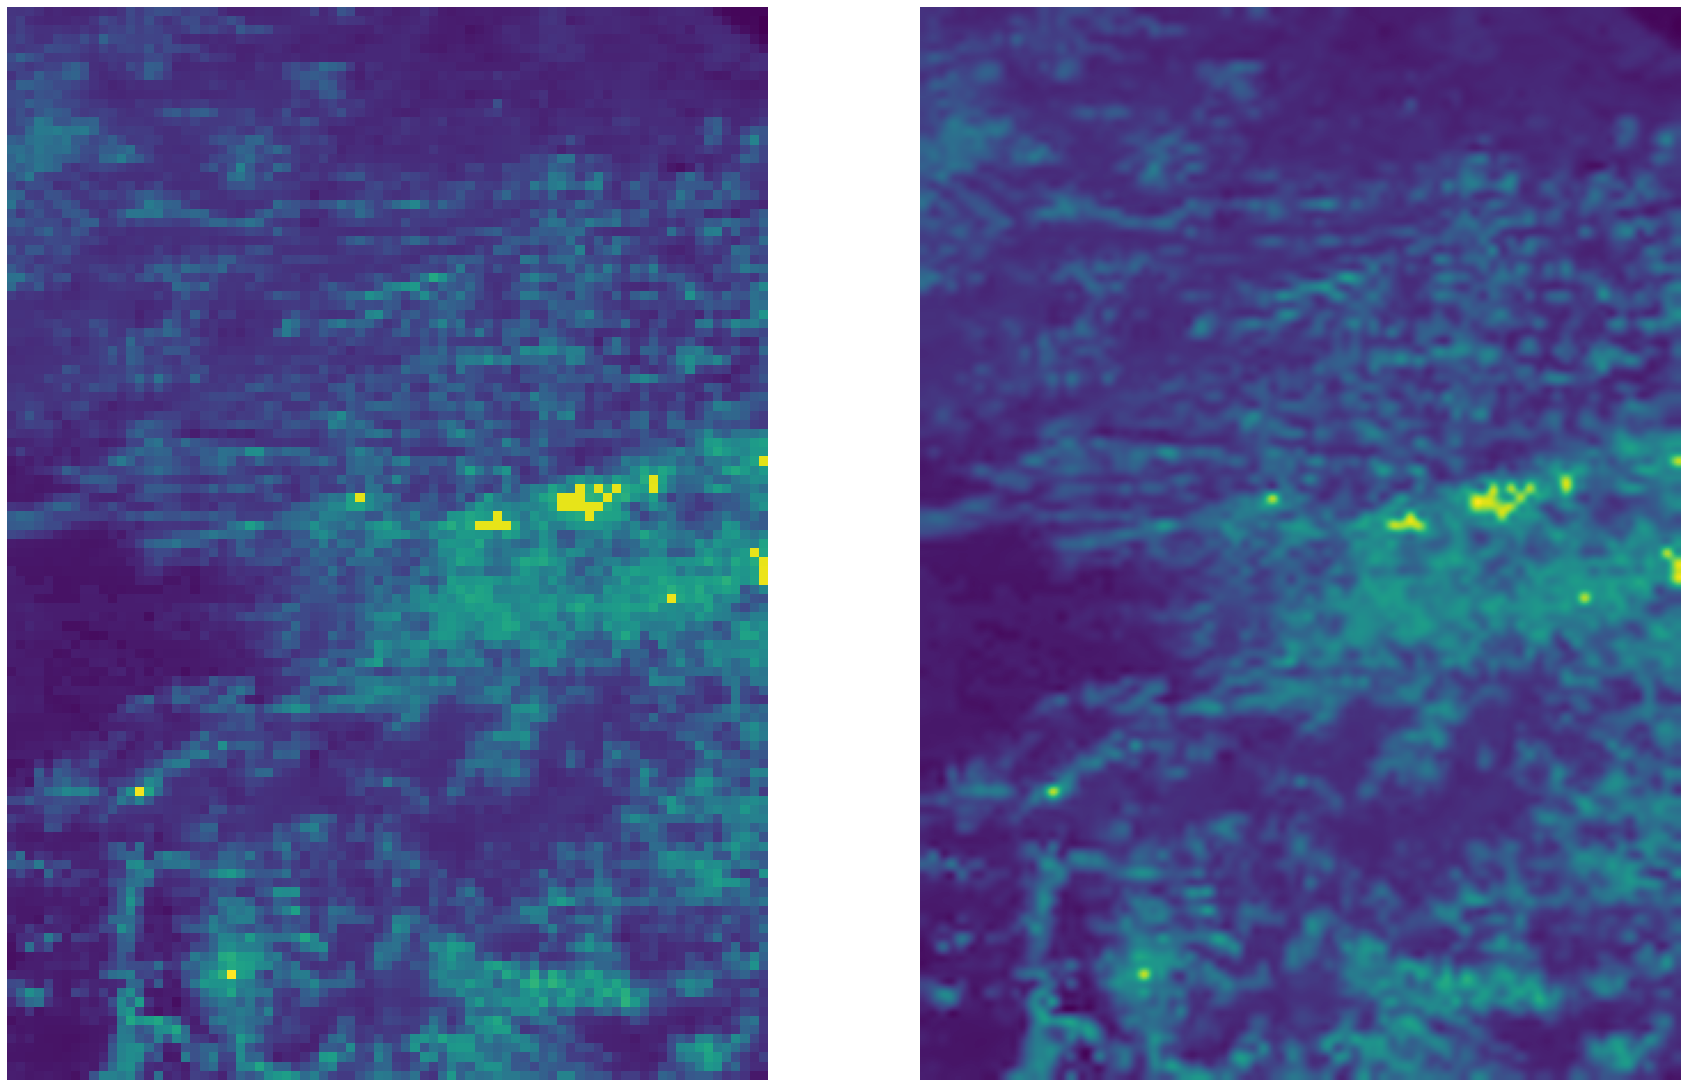

In [50]:
res_magnify_ratio = 4
arr_clip_res_up = cv2.resize(
    arr_etc,
    dsize=None,
    fx=res_magnify_ratio,
    fy=res_magnify_ratio,
    interpolation=cv2.INTER_CUBIC
)
fig, ax = plt.subplots(1,2)
ax[0].imshow(arr_etc)
ax[0].axis('off')
ax[1].imshow(arr_clip_res_up)
ax[1].axis('off')
fig.subplots_adjust(right=4, top=4)

## super resolution
- reference
    - https://towardsdatascience.com/deep-learning-based-super-resolution-with-opencv-4fd736678066
    - https://github.com/60hz-io/research_experimental/blob/main/super_res/cv2_superres.ipynb
    - https://github.com/opencv/opencv_contrib/tree/db16caf6ceee76b43b94c846be276e92a43e9700/modules/dnn_superres

In [17]:
from cv2 import dnn_superres
from cv2 import dnn
from src.config import (
    SUPERRES_MODEL_PATH
)

In [19]:
# work with float models: ESPCN, FSRCNN, LapSRN

In [121]:
model = 'EDSR'
sr_mag_ratio = 2
sr = dnn_superres.DnnSuperResImpl_create()
model_path = f'/mnt/sda1/research/data/superres_models/{model}_x{sr_mag_ratio}.pb'
sr.readModel(model_path)
sr.setModel(model.lower(), sr_mag_ratio, )
# sr.setPreferableBackend(dnn.DNN_BACKEND_CUDA)

In [122]:
target_arr = arr_etc.copy()

In [123]:
arr_img = np.array(Image.fromarray(np.uint8(target_arr/(2**16-1) * 255)).convert('RGB'))

In [124]:
# arr_img = np.stack([np.float32(target_arr/(2**16-1))]*3).transpose(1,2,0)

In [125]:
a = sr.upsample(arr_img)[...,0]/255*(2**16-1)

In [126]:
# aa = (a/255*2**16).astype(target_arr.dtype)[...,0]

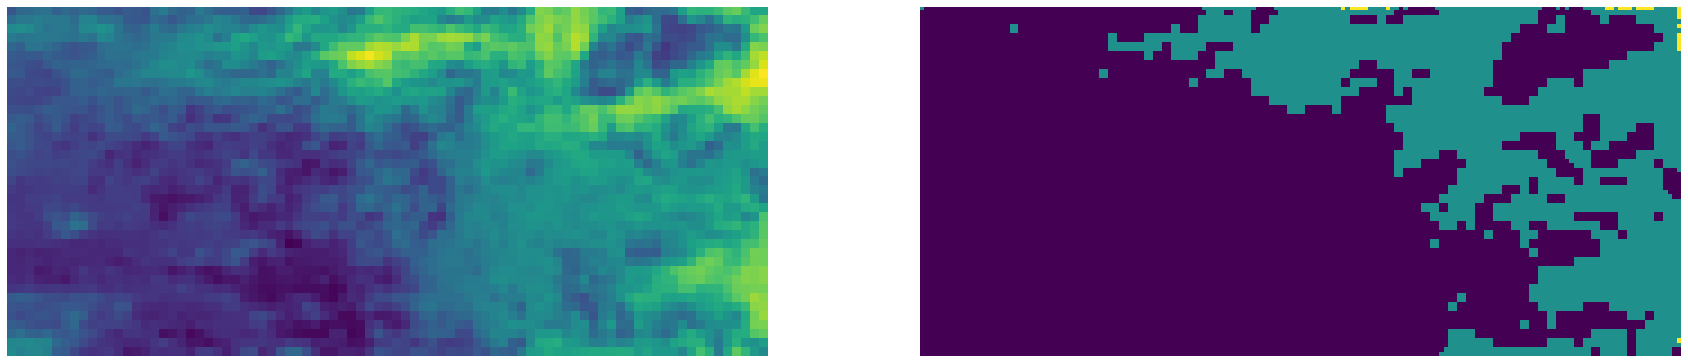

In [127]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(target_arr)
ax[0].axis('off')
ax[1].imshow(a)
ax[1].axis('off')
fig.subplots_adjust(right=4, top=4)

In [120]:
target_arr.shape

(39, 85)